# Проект: вариант 2

Импортируем необходимые библиотеки

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, shapiro, norm
import pandahouse as ph
import requests
from urllib.parse import urlencode 

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'  # ссылка на файл groups.csv
public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  # ссылка на файл groups_add.csv
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'  # ссылка на файл active_studs.csv
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'  # ссылка на файл checks.csv

# Получаем загрузочные ссылки
final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))
response_groups = requests.get(final_url_groups)
download_url_groups = response_groups.json()['href']

final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
response_groups_add = requests.get(final_url_groups_add)
download_url_groups_add = response_groups_add.json()['href']

final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
response_active_studs = requests.get(final_url_active_studs)
download_url_active_studs = response_active_studs.json()['href']

final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
response_checks = requests.get(final_url_checks)
download_url_checks = response_checks.json()['href']

# Задание 1. A/B–тестирование

Условие:

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные:

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### 1.1. Считаем данные и проверим их корректность, имеются ли в них дубликаты/пропущенные значения

##### 1.1.1. Считываем файл  groups.csv

Cчитываем файл с основной информацией о пользователях и их группах

In [3]:
main_group = pd.read_csv(download_url_groups, sep=';')
main_group.head()


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверяем размер датафрейма

In [70]:
main_group.shape 

(74484, 2)

Проверяем на наличие пропущенных значений

In [5]:
main_group.isna().sum() 

id     0
grp    0
dtype: int64

Проверяем датафрейм на дубликаты по id, т.к. размер датафрейма равен размеру датафрейму с уникальными значениями, то дубликатов не обнаружено

In [71]:
main_group.nunique()

id     74484
grp        2
dtype: int64

##### 1.1.2. Считываем файл groups_add.csv

In [4]:
additional_group = pd.read_csv(download_url_groups_add, sep=',') 
additional_group.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Проверяем размер датафрейма

In [8]:
additional_group.shape 

(92, 2)

Проверяем на наличие пропущенных значений

In [72]:
additional_group.isna().sum() 

id     0
grp    0
dtype: int64

Проверяем датафрейм на дубликаты по id, т.к. размер датафрейма равен размеру датафрейму с уникальными значениями, то дубликатов не обнаружено

In [74]:
additional_group.nunique()

id     92
grp     2
dtype: int64

##### 1.1.3. Считываем файл checks.csv

In [5]:
checks_exp = pd.read_csv(download_url_checks, sep=';')
checks_exp.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Переименуем колонку, потребуется для дальнейшего соединения таблиц

In [11]:
checks_exp = checks_exp.rename(columns={'student_id': 'id'})

Проверяем размер датафрейма

In [75]:
checks_exp.shape

(541, 2)

Проверяем на наличие пропущенных значений

In [76]:
checks_exp.isna().sum()

id     0
rev    0
dtype: int64

Проверяем датафрейм на дубликаты по student_id, т.к. размер датафрейма равен размеру датафрейму с уникальными значениями, то дубликатов не обнаружено, соответственно каждый пользователь провел по одной оплате

In [77]:
checks_exp.id.nunique()

541

##### 1.1.4. Считываем файл  active_studs.csv

Считываем файл, где пользователи были на платформе в дни

In [6]:
studs_exp = pd.read_csv(download_url_active_studs, sep=',')
studs_exp.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Переименуем колонку, потребуется для дальнейшего соединения таблиц

In [18]:
studs_exp = studs_exp.rename(columns={'student_id': 'id'})

Проверяем размер датафрейма 

In [81]:
studs_exp.shape 

(8341, 1)

Проверяем на наличие пропущенных значений

In [82]:
studs_exp.isna().sum() 

id    0
dtype: int64

Проверяем датафрейм на дубликаты по student_id, т.к. размер датафрейма равен размеру датафрейму с уникальными значениями, то дубликатов не обнаружено

In [83]:
studs_exp.nunique() 

id    8341
dtype: int64

##### 1.1.5. Вывод: проверка по всем файлам завершена, все данные корректные, без пустых значений и дубликатов.

#### 1.2. Объединение данных groups.csv и groups_add.csv

In [12]:
total_group = pd.concat([main_group, additional_group])
total_group.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверим размер данных, все корректно сложилось

In [13]:
total_group.shape

(74576, 2)

Посмотрим на распределение пользователей в обоих группах, как видим, в тестовой группе гораздо больше пользователей.

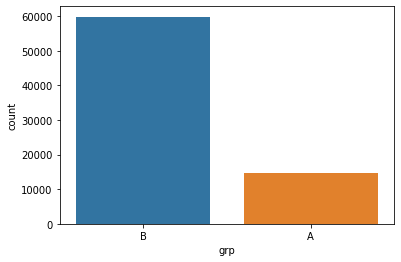

In [14]:
sns.countplot(data=total_group, x='grp')

Выведем их процентное соотношение

In [15]:
total_group.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

#### 1.3. Объединение общей группы с группой пользователей, которые зашли на платформу в день эксперимента

In [19]:
exp_group = studs_exp.merge(total_group, how='left', on='id')
exp_group.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


Проверям размер датафрейм, он соответстуем размеру файла active_studs.csv, следовательно мердж прошел успешно

In [89]:
exp_group.shape

(8341, 4)

Проверяем датафрейм на пропущенные значения

In [92]:
exp_group.isna().sum() 

id          0
grp         0
rev         0
purchase    0
dtype: int64

Посмотрим на распределение пользователей в обоих группах в день эксперимента, как видим, в тестовой группе все также больше пользователей.

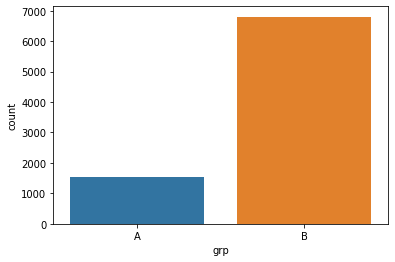

In [20]:
sns.countplot(data=exp_group, x='grp')

Выведем их процентное соотношение

In [21]:
exp_group.grp.value_counts(normalize=True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

В целом можно сказать, что в процентном соотношения контрольная и тестовая группа в день эксперимента особо не отличилась от групп, до дня эксперимента.

#### 1.4. Объединим полученные данные с оплатами

Объдиним датафреймы с оплатами и заполним пропущенные значения нулями, т.к. пользователь был в день эксперимента, но оплату не совершил

In [22]:
exp_group = exp_group.merge(checks_exp, how='left', on='id').fillna(0)
exp_group.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Проверим размер полученной таблицы, мердж выполнен успешно

In [23]:
exp_group.shape

(8341, 3)

#### 1.5. Добавим в таблицу колонку, которая отражает была ли совершена покупка

In [24]:
exp_group['purchase'] = np.where(exp_group.rev > 0, 1, 0) # с помощью метода where из библиотеки numpy добавим колонку
# purchase, в которой отобразим была ли совершена покупка (1) или нет (0)

In [25]:
exp_group.head()

,id,grp,rev,purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


Посчитаем сколько пользователей совершило покупку

In [26]:
exp_group.purchase.sum() 

392

Отберем пользователей, которые совершили покупку и отобразим их распределение по группам

In [27]:
exp_group_buyers = exp_group.query('purchase > 0')
exp_group_buyers.head()

,id,grp,rev,purchase
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1


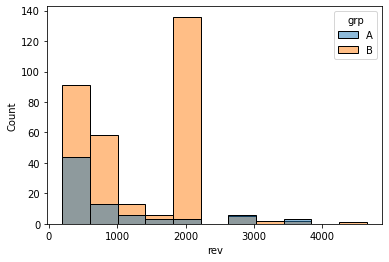

In [28]:
sns.histplot(data=exp_group_buyers, x='rev', hue='grp')

По графику можно предварительно сказать, что больше покпок было совершено пользователями из тестовой группы.
Посмотрим на процентное соотношение пользователей, которые совершили покупку в день эксперимента.
В целом соотношение пользователей практически не поменялось.

In [29]:
exp_group_buyers.grp.value_counts(normalize=True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

#### 1.6. Подготовим датафрейм для анализа

Группируем данные по тестовой и контрольной группам, и высчитываем количество пользователей в группах, суммарный доход, а также количество покупок в каждой из групп

In [112]:
analys_frame = exp_group.groupby('grp').agg({'id': 'count', 'rev': 'sum', 'purchase': 'sum'}).reset_index() \
    .rename(columns={'grp': 'group', 'id': 'count_id', 'rev': 'total_revenue', 'purchase': 'count_purchase'})
analys_frame 

,group,count_id,total_revenue,count_purchase
0,A,1538,72820.0000,78
1,B,6803,394974.0035,314


#### 1.7. Посчитаем CR, ARPU, ARPPU из полученного датафрейма

In [113]:
analys_frame['CR'] = analys_frame.count_purchase / analys_frame.count_id * 100
# считаем CR: количество покупок / количество пользователей * 100

In [114]:
analys_frame['ARPU'] = analys_frame.total_revenue / analys_frame.count_id
# считаем ARPU: суммарный доход / количество пользователей

In [115]:
analys_frame['ARPPU'] = analys_frame.total_revenue / analys_frame.count_purchase
# считаем ARPPU: суммарный доход / платящих юзеров

In [116]:
analys_frame # получили итоговый датафрейм для проверки гипотез

,group,count_id,total_revenue,count_purchase,CR,ARPU,ARPPU
0,A,1538,72820.0000,78,5.071521,47.347204,933.589744
1,B,6803,394974.0035,314,4.615611,58.058798,1257.878992


#### 1.8. Выдвигаем гипотезы

**1)** -***H0:*** новая механика оплаты услуг на сайте не влияет на конверсию пользователей в покупку
   
   -***H1:*** новая механика оплаты услуг на сайте влияет на конверсию пользователей в покупку

**2)** -***H0:*** новая механика оплаты услуг на сайте не влияет на средний доход, получаемый платящего от пользователя
   
   -***H1:*** новая механика оплаты услуг на сайте влияет на средний доход, получаемый от платящего пользователя

**3)**  -***H0***: новая механика оплаты услуг на сайте не влияет на средний доход, получаемый всех пользователей

  -***H1:*** новая механика оплаты услуг на сайте влияет на средний доход, получаемый от всех пользователей

##### 1.8.1. Проведем 1-ый тест

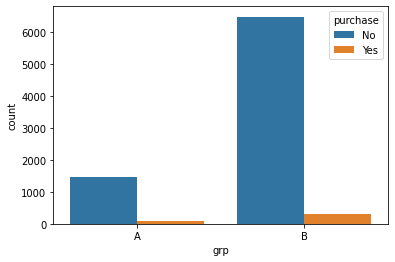

In [43]:
ax = sns.countplot(data=exp_group, x='grp', hue='purchase') # отобразим конверсию пользователей в покупку
ax.legend(title='purchase', labels=['No', 'Yes'])

In [44]:
crosstab_1 = pd.crosstab(exp_group.grp, exp_group.purchase) #составляем таблицу сопряженности, 0-не было оплаты, 1 - была оплата
crosstab_1

purchase,0,1
grp,,
A,1460,78
B,6489,314


In [45]:
chi2_contingency(crosstab_1) 

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

После применения критерия хи-квадрат Пирсона видим, что значение p-value равно примерно 0.48, а это значит, что мы не можем отвергнуть нулевую гипотезу, следовательно новая механика оплаты услуг на сайте не влияет никаким образом на CR пользователя в покупку

##### 1.8.2.  Проведем 2-ой тест

Отобразим график ARPPU для контрольной и тестовой группы

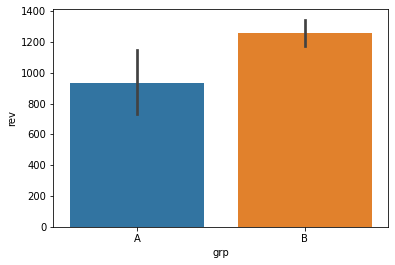

In [41]:
ax = sns.barplot(data=exp_group_buyers, x='grp', y='rev')

Повторно отобразим график распределения тестовой и контрольной групп

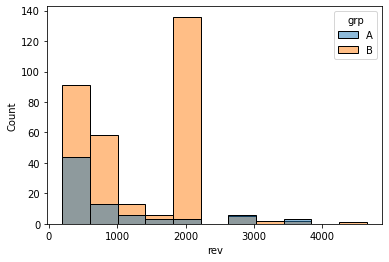

In [40]:
sns.histplot(data=exp_group_buyers, x='rev', hue='grp')

Исходя из графика видно, что распределения не являются нормальными, для большей точности проведем тест Шапиро-Уилко на нормальность.

In [56]:
exp_group_buyers_A = exp_group_buyers.query('grp == "A"').rev # выделим контрольную группу
shapiro(exp_group_buyers_A)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

Проведя тест Шапиро-Уилко на контрольной группе видим, что p-value сильно меньше 0.05, следовательно распределение не являтся нормальным

In [55]:
exp_group_buyers_B = exp_group_buyers.query('grp == "B"').rev # выделим тестовую группу
shapiro(exp_group_buyers_B)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Проведя тест Шапиро-Уилко на тестовой группе видим, что p-value сильно меньше 0.05, следовательно распределение не являтся нормальным

В качестве проверки на статистически значимые различия среднего будем использовать bootstrap. Напишем функцию:

In [97]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_iter = 2000, # количество бутстрап-выборок
    statistic = np.mean, # интересующая статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in range(boot_iter): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

Передадим аргументы в ранее написанную функцию

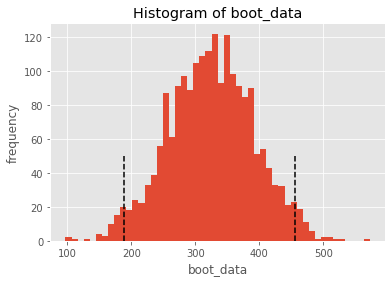

In [106]:
bootstrap_1 = get_bootstrap(exp_group_buyers_B, exp_group_buyers_A, 
                            boot_iter=2000)

Отобразим доверительный интервал

In [107]:
bootstrap_1['ci']

,0
0.025,188.440136
0.975,455.302638


Отобразим p-value

In [108]:
bootstrap_1['p_value']

1.0996736479133404e-06

Как видим после бутстрапа 0 не входит в доверительный интервал и p-value сильно меньше 0.05, следовательно новая механика оплаты услуг на сайте влияет на средний доход, получаемый от платящего пользователя

##### 1.8.3. Проведем 3-ий тест


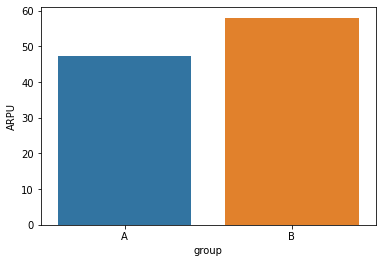

In [39]:
ax = sns.barplot(data=analys_frame, x='group', y='ARPU') # график ARPU для контрольной и тестовой группы

По графику видим, что ARPU в тестовой группе чуть выше, чем в контрольной

Посмотрим на распределение суммы покупок в обеих группах

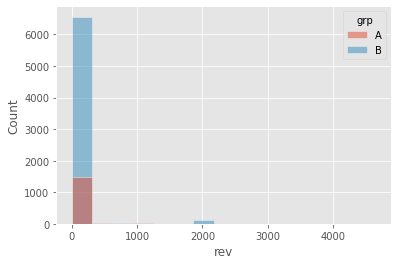

In [123]:
sns.histplot(data=exp_group, x='rev', hue='grp')

Исходя из графика видим, что большая часть пользователей из контрольной и тестовой группы в основном не совершали покупки, ту самую малую часть пользователей, которая совершала покупки, на графике почти не видно.
Отберем группы и применим бутстрап для определения наличия статистически значимых различий.

In [130]:
control_series_group_1 = exp_group.query('grp == "A"').rev # отберем из датафрейма серию данных с контрольной группой
# всех пользователей
control_series_group_1

0       0.0
1       0.0
3       0.0
7       0.0
21      0.0
       ... 
8317    0.0
8320    0.0
8326    0.0
8330    0.0
8334    0.0
Name: rev, Length: 1538, dtype: float64

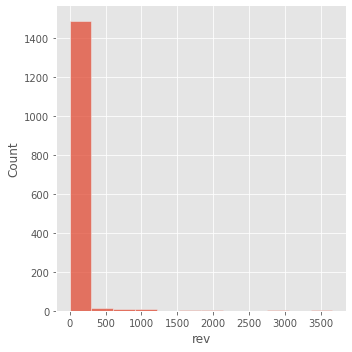

In [131]:
sns.displot(control_series_group_1) # построим график и видим, что распределение ненормальное

In [132]:
test_series_group_1 = exp_group.query('grp == "B"').rev # отберем из датафрейма серию данных с тестовой группой
# всех пользователей
test_series_group_1

2         0.0
4         0.0
5         0.0
6         0.0
8         0.0
        ...  
8336      0.0
8337      0.0
8338      0.0
8339    290.0
8340      0.0
Name: rev, Length: 6803, dtype: float64

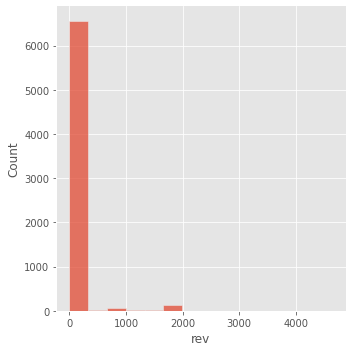

In [133]:
sns.displot(test_series_group_1) # построили график и видим, что распределение ненормальное

Исходя из графиков видим, что распределения не являются нормальными, проверим данную теорию с помощью теста Шапиро-Уилко

In [136]:
shapiro(control_series_group_1)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

In [137]:
shapiro(test_series_group_1)

ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

На обеих группах p-value > 0.05, следовательно распределения не прошли проверку на нормальность по тесту Шапиро-Уилко

Применим ранее написанную функцию бутстрапа для определения статистически значимых различий среднего среди всех пользователей в контрольной и тестовой группах

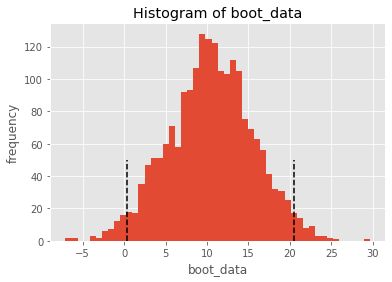

In [143]:
bootstrap_2 = get_bootstrap(test_series_group_1, control_series_group_1, 
                            boot_iter=2000)

Отобразим доверительный интервал

In [144]:
bootstrap_2['ci']


,0
0.025,0.324276
0.975,20.463336


Отобразим p-value

In [146]:
bootstrap_2['p_value'] 

0.04001741176699113

С помощью данного теста видим, что 0 не входит в доверительный интервал, а также p-value < 0.05. В связи с этим можем сделать вывод, что среднее в двух группах статистически значимо различается

##### 1.9. Вывод
Было проведено три статистических теста, в первом мы сравнивали CR в обеих группах с помощью критерия хи-квадрат Пирсона и выявили, что новая механика оплаты услуг на сайте не влияет никаким образом на CR пользователя в покупку, далее мы решили сравнить средний доход у платящих пользователей и всех пользователей с помощью бутстрапа, где получили статистически значимые различия в обоих экспериментах. Исходя из этого нам необходимо внести новую механику оплаты услуг на сайте, с помощью которой у нас повысится средний чек на пользователя.

# Задание 2. SQL

Очень усердные ученики.

Условие:

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

#### 2.1. Настроим подключение ClickHouse -> JupyterHub 

In [51]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     } #создаем словарь, заполняем данные для подключения, будем использовать в дальнейшем библиотеку pandahouse

#### 2.2. Пишем запрос согласно условию задачи 'Очень усердные ученики'

In [52]:
query_1 = """SELECT st_id, COUNT(subject) as quantity
FROM default.peas
WHERE correct = 1 AND toStartOfMonth(timest) == toStartOfMonth(now())
GROUP BY st_id
HAVING COUNT(subject) >= 20""" # создаем запрос, согласно условию задачи

In [53]:
query_1_read = ph.read_clickhouse(query=query_1, connection=connection_default) # с помощью библиотеки pandahouse считываем
# запрос
query_1_read # ОТВЕТ: получили пустую таблицу, т.к. учеников за данный месяц нет, максимальная дата в таблице: 2021-10-31

,st_id,quantity


In [54]:
query_2 = """SELECT st_id, COUNT(subject) as quantity
FROM default.peas
WHERE correct = 1
GROUP BY st_id
HAVING COUNT(subject) >= 20""" # перепишем запрос, уберем из фильтрации дату и проверим за все время

In [55]:
query_2_read = ph.read_clickhouse(query=query_2, connection=connection_default) # считываем 2-ой запрос
query_2_read # ОТВЕТ: получили таблицу, в которой усердных учеников оказалось 136 человек, согласно условию задачи

,st_id,quantity
0,700123,126
1,171209,26
2,219630,53
3,416918,26
4,877738,22
...,...,...
131,375731,24
132,71465,38
133,936163,29
134,790532,22


#### 2.3. Оптимизация воронки

Условие:

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [56]:
query_3 = """SELECT test_grp, 
       SUM(total_money)/COUNT(DISTINCT studs.st_id) as ARPU,
       sumIf(total_money,active_stud=1)/SUM(active_stud) as ARPAU,
       countIf(total_money>0)/COUNT(DISTINCT studs.st_id) AS CR, 
       countIf(total_money>0 and active_stud=1)/SUM(active_stud) as CR_active,
       countIf(total_money>0 and math_active_stud=1 and bought_math_course=1)/SUM(math_active_stud) as CR_math_active
FROM default.studs as studs
LEFT JOIN 
    (SELECT 
        st_id, 
        SUM(money) AS total_money,
        SUM(
            CASE 
            WHEN subject='Math'
            THEN 1
            ELSE 0
            END) AS bought_math_course
     FROM default.final_project_check
     GROUP BY st_id) AS checks
ON studs.st_id=checks.st_id
LEFT JOIN (SELECT 
               st_id, 
               (CASE 
               WHEN SUM(correct) > 10
               THEN 1
               ELSE 0
               END AS active_stud),
               (CASE 
               WHEN countIf(subject='Math' and correct=1)>=2
               THEN 1
               ELSE 0
               END AS math_active_stud)
           FROM default.peas 
           GROUP BY st_id) AS activity
ON studs.st_id=activity.st_id
GROUP BY test_grp""" # пишем запрос, согласно условию задачи

In [57]:
query_3_read = ph.read_clickhouse(query=query_3, connection=connection_default) # считываем 3-ий запрос
query_3_read # ОТВЕТ: получили таблицу, разделенную на 2 группы(control и pilot), вычеслили ARPU, ARPAU, CR в покупку, 
# СR активного пользователя в покупку, CR пользователя из активности по математике

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math_active
0,control,4540.983607,10000.000000,0.049180,0.106061,0.061224
1,pilot,11508.474576,28267.326733,0.108475,0.247525,0.095238


# Задание 3. Python

Задача:

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [151]:
def recalc_metrics(main_group, new_group): # определим функцию с 2-мя входящими аргументами, основными данными и новыми
    new_group = new_group.rename(columns= {new_group.columns[0]: 'id', new_group.columns[1]: 'grp'}) # переименуем колонки для
    # того, чтобы идентификаторы совпадали и мы могли соединить таблицы
    total_group = pd.concat([main_group, new_group]) # соединяем таблицы
    studs_copy = studs_exp.copy() # копируем файл с данные о пользователях в день эксперимента
    studs_copy['active'] = 1 # создаем колонку и помечаем 1 тех, кто учавствовал в эксперименте
    studs_copy = studs_copy.rename(columns = {'student_id': 'id'}) # переименуем колонки для дальнейшего мерджа
    studs_active =  total_group.merge(studs_copy, on='id', how='left').fillna(0) # соединяем таблицы и заполняем пустые ячейки 0
    studs_active['active'] = studs_active['active'].astype('int') # преобразовываем тип данных в целочисленный
    
    checks_exp_copy = checks_exp.copy() # создаем копию файла с данными о покупке
    checks_exp_copy['purchase'] = 1 # создаем в файле колонку, в которой обозначим 1 кто совершал покупку, в дальнейшем после
    # мерджа заполним 0, кто не совершал
    checks_exp_copy = checks_exp_copy.rename(columns = {'student_id': 'id'}) # переименуем колонку для мерджа
    paying_studs =  studs_active.merge(checks_exp_copy, on='id', how='left').fillna(0) # соединим таблицы и пустые значения
    # заполним 0, тех кто не совершал покупки
    paying_studs['purchase'] = paying_studs['purchase'].astype('int') # преобразовываем тип данных в целочисленный
    
    paying_a = paying_studs.query('active == 1 and grp == "A"') # отберем платящих пользователей группы А
    paying_b = paying_studs.query('active == 1 and grp == "B"') # отберем платящих пользователей группы B
    
    cr_a = paying_a.purchase.sum() / (paying_a.shape[0]) * 100 # вычислим CR для группы А
    cr_b = paying_b.purchase.sum() / (paying_b.shape[0]) * 100 # вычислим CR для группы B
    arppu_a = paying_a.rev.sum() / paying_a.purchase.sum() # вычислим ARPPU для группы А
    arppu_b = paying_b.rev.sum() / paying_b.purchase.sum() # вычислим ARPPU для группы B
    arpu_a = paying_a.rev.mean() # вычислим ARPU для группы А
    arpu_b = paying_b.rev.mean() # вычислим ARPU для группы B
   
    print(f'Группа A: CR={cr_a}; ARPPU={arppu_a}; ARPU={arpu_a} | Группа B: CR={cr_b}; ARPPU={arppu_b}; ARPU={arpu_b}')
    # напечатаем результат вычислений
    return {'Group': ['A', 'B'],
            'CR': [cr_a, cr_b],
            'ARPPU': [arppu_a, arppu_b],
            'ARPU': [arpu_a, arpu_b]} # вернем полученные вычисления


In [152]:
recalc_metrics(main_group, additional_group) # вызовем функцию и передадим аргументы

Группа A: CR=5.071521456436931; ARPPU=933.5897435897435; ARPU=47.34720416124838 | Группа B: CR=4.615610759958842; ARPPU=1257.8789920382167; ARPU=58.058798103777754


{'Group': ['A', 'B'],
 'CR': [5.071521456436931, 4.615610759958842],
 'ARPPU': [933.5897435897435, 1257.8789920382167],
 'ARPU': [47.34720416124838, 58.058798103777754]}

In [153]:
def recalc_metrics_table(df): # определяем функцию для визуализации
    recalc_metrics_df = pd.DataFrame(df) # Создаем датафрейм с метриками
    fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
    sns.barplot(x="Group", y="CR", data=recalc_metrics_df, ax=axs[0]).set_title('CR') # график CR по группе А и B
    sns.barplot(x="Group", y="ARPPU", data=recalc_metrics_df, ax=axs[1]).set_title('ARPPU') # график ARPPU по группе А и B
    sns.barplot(x="Group", y="ARPU", data=recalc_metrics_df, ax=axs[2]).set_title('ARPU') # график ARPU по группе А и B

Группа A: CR=5.071521456436931; ARPPU=933.5897435897435; ARPU=47.34720416124838 | Группа B: CR=4.615610759958842; ARPPU=1257.8789920382167; ARPU=58.058798103777754


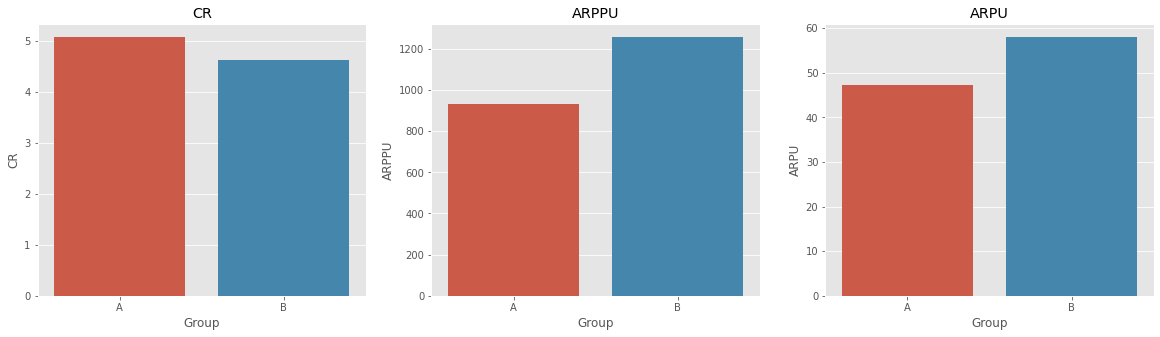

In [154]:
recalc_metrics_table(recalc_metrics(main_group, additional_group))